In [1]:
from netCDF4 import Dataset
#ds=xr.Dataset({'zMeas':zMeasX,'bcf':bcfX,'bsfc':bsfcX,'bzd':bzdX,'pFlag':pFlagX,'bbFlag':bbFlagX,'dm':dmX,'pRate':pRateX,'zeroDegAlt':zeroDegAltX})
#compres={'zlib':True,'complevel':5}
#encoding={'zMeas':compres,'bcf':compres,'bsfc':compres,'bzd':compres,'pFlag':compres,'bbFlag':compres,'dm':compres,'pRate':compres,'zeroDegAlt':compres}

#ds.to_netcdf('dpr_cmb.nc',encoding=encoding)

with Dataset('dpr_cmb.nc') as f:
    zMeas=f['zMeas'][:]
    bcf=f['bcf'][:]
    bsfc=f['bsfc'][:]
    bzd=f['bzd'][:]
    pFlag=f['pFlag'][:]
    bbFlag=f['bbFlag'][:]
    dm=f['dm'][:]
    pRate=f['pRate'][:]
    nearSfcPrecip=f['nearSfcPrecip'][:]
    PIAhybrid=f['PIAhybrid'][:]


1964


(0.0, 120.0)

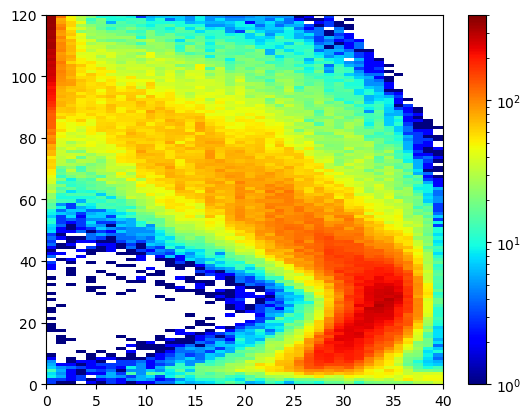

In [2]:
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

a=np.nonzero(nearSfcPrecip[:,16]>30)
print(len(a[0]))
cfad=np.zeros((40,176))
for i in range(len(a[0])):
    for k in range(0,bsfc[a[0][i],16,0]):
        ik=int(zMeas[a[0][i],16,k,0]-10)
        if ik>=0 and ik<40:
            cfad[ik,k]+=1

plt.pcolormesh(cfad[:,::-1].T,cmap='jet',norm=LogNorm())
plt.colorbar()
plt.ylim(0,120)

In [3]:
nt=zMeas.shape[0]
for i in range(nt):
    for j in range(32):
        zMeas[i,j,bcf[i,j]:,0]=0
        zMeas[i,j,bcf[i,j]:,1]=0


In [4]:
zMeas[zMeas<0]=0
zMeas2=np.log10(0.5*10**(0.1*zMeas[:,:,::2,:])+0.5*10**(0.1*zMeas[:,:,1::2,:]))*10

In [5]:
zMeas2[zMeas2<0]=0
zMean=np.mean(zMeas2,axis=(0,1))
zStd=np.std(zMeas2,axis=(0,1))


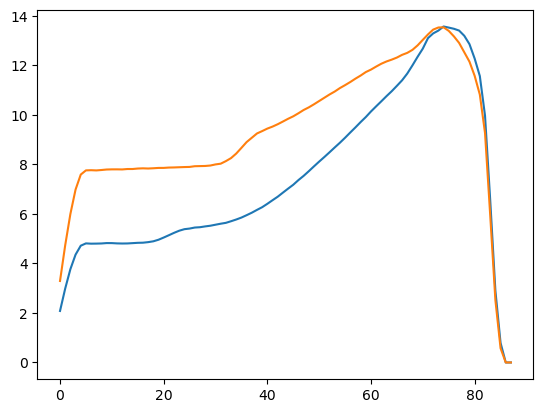

In [6]:

zScaled=zMeas2.copy()
nt=zScaled.shape[0]
for i in range(nt):
    zScaled[i,:,:,0]=(zMeas2[i,:,:,0]-zMean[:,0])/(zStd[:,0]+1e-6)
    zScaled[i,:,:,1]=(zMeas2[i,:,:,1]-zMean[:,1])/(zStd[:,1]+1e-6)
#print(zMean)
plt.plot(zMean[:,0])
plt.plot(zMean[:,1])
a=np.nonzero(nearSfcPrecip[:,16]>30)
#plt.plot(zMeas2[a[0][0],16,:,0])
#print(bsfc[a[0][0],16,0])


In [7]:
#zMeas[zMeas<0]=0
#plt.pcolormesh(zmean1[15:18,::-1,0].T,vmin=0,vmax=40,cmap='jet')
#i1=a[0][0]+2
#plt.subplot(211)
#plt.pcolormesh(pRate[i1,:,::-1].T,cmap='jet',norm=LogNorm(vmin=0.01,vmax=30))
#plt.ylim(0,40)
#plt.subplot(212)
#plt.pcolormesh(zMeas[i1,:,::-1,0].T,cmap='jet',vmin=0,vmax=40)
#plt.ylim(0,80)

In [8]:
print(np.max(bbFlag))
bbFlag[bbFlag<0]=-3
xbb=bbFlag[:,:,np.newaxis]
xbzd=(bzd[:,:,np.newaxis]-144)/5.
xsfc=(bsfc[:,:,0:1]-173)/5.
xpia=(PIAhybrid[:,:,0:1]-0.3)/0.7
xbcf=(176-bcf[:,:,np.newaxis])/10.
xpflag=(pFlag[:,:,np.newaxis]-5)/5

3


In [9]:
PIAhybrid[PIAhybrid<0]=0
#print(PIAhybrid.mean(axis=(0,1)))
#print(PIAhybrid.std(axis=(0,1)))
#print(pFlag.mean(axis=(0,1)))
#print(pFlag.std(axis=(0,1)))
#print(pFlag.max())
#print(pFlag.min())

x1D=np.concatenate((xbb,xbzd,xsfc,xpia,xbcf,xpflag),axis=2)

In [131]:
from sklearn.model_selection import train_test_split

logPrate=np.log10(1+pRate/0.01)
dm[dm<0]=0
yout=np.concatenate((logPrate[:,:,:,np.newaxis],dm[:,:,:,np.newaxis]),axis=3)
print(zScaled.shape)
zSc_train,zSc_test,x_train,x_test,yout_train,yout_test=train_test_split(zScaled[:,12:20,:,:],x1D[:,12:20,:],yout[:,12:20,:,:],test_size=0.1,random_state=42)

(73944, 32, 88, 2)


In [132]:
from torch.utils.data import Dataset, DataLoader
import torch
class CustomDataset(Dataset):
    def __init__(self, x1_train, x2_train, y_train, transform=None):
        self.x1_train = torch.tensor(x1_train, dtype=torch.float32, device='cpu').swapaxes(1,3)
        self.x2_train = torch.tensor(x2_train, dtype=torch.float32, device='cpu') 
        self.y_train = torch.tensor(y_train, dtype=torch.float32, device='cpu').swapaxes(1,3)
        self.transform = transform

    def __len__(self):
        return len(self.x1_train)

    def __getitem__(self, idx):
        sample = self.x1_train[idx], self.x2_train[idx], self.y_train[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample

# Define any transformations if necessary
# Example of transformation
# transform = transforms.Compose([
#     transforms.ToTensor(),
# ])

# Create custom dataset
# Pass transform if any
# train_dataset = CustomDataset(x_train, y_train, transform=transform)
train_dataset = CustomDataset(zSc_train[:,:,-64:,:], x_train, yout_train[:,:,-64:,:])
batch_size = 64
shuffle = True
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable

In [133]:
ic=0
for zsc, x_batch, y_batch in train_loader:
    ic+=1
    #break

In [134]:
print(zsc.shape)
print(x_batch.shape)
print(y_batch.shape)

torch.Size([53, 2, 64, 8])
torch.Size([53, 8, 6])
torch.Size([53, 2, 64, 8])


In [112]:
print(ic)
print(zsc.shape)
print(x_batch.shape)
print(y_batch.shape)
import torch
import torch.nn as nn
import torch.nn.functional as F

class projNet(nn.Module):
    def __init__(self, nin, nout, nh):
        super(projNet, self).__init__()
        self.nin=nin
        self.nout=nout
        self.nh=nh
        self.fc1 = nn.Linear(nin, nh)
        self.fc2 = nn.Linear(nh, nh)
        self.fc3 = nn.Linear(nh, nout)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


225
torch.Size([64, 2, 64, 32])
torch.Size([64, 32, 5])
torch.Size([64, 2, 64, 32])


In [135]:
 
projOperator=projNet(6,2*64,32)
from neuralop.models import FNO

model_fno = FNO(n_modes=(16, 4), hidden_channels=16,
                in_channels=4, out_channels=2)

x_test=torch.randn(53,8,64,4)
x_test=x_test.swapaxes(1,3)
y_test=model_fno(x_test)

In [80]:
print(model_fno.parameters())
print(projOperator.parameters())

<generator object Module.parameters at 0x179a2d7b0>
<generator object Module.parameters at 0x179a2d7b0>


In [138]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable



# Define loss function and optimizer
criterion = nn.MSELoss()
all_parameters = list(model_fno.parameters()) + list(projOperator.parameters())

optimizer = optim.Adam(all_parameters, lr=0.001)
num_epochs = 2
for epoch in range(num_epochs):
    running_loss = 0.0
    ic=0
    for zsc, x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        x_cut=x_batch[:,:,:]
        yout_1=projOperator(x_cut.view(-1,6))
        yout_2=yout_1.view(-1,8,64,2)
        yout_3=yout_2.swapaxes(1,3)
        xin=torch.cat((zsc[:,:,:,:],yout_3),dim=1)
        yout_3=model_fno(xin)
        rms=criterion(yout_3, y_batch)
        rms.backward()
        optimizer.step()
        ic+=1
        #print(rms.item())
        running_loss += rms.item()
        if ic%50==0:
            print(running_loss/ic)
            #break
        
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

    

0.04647021308541298
0.040755485072731974
0.03733104425172011
0.035021041603758934
0.03332765945792198
0.03194220575814446
0.030817429769252027
0.034688942222855984
0.03536512960162428
0.03446878237277269
0.03362895422699776
0.03269767629603545
0.03195117440361243
0.03128531507615532
0.030650958567857742
0.03009533975739032
0.029620731076335206
0.02912969532940123
0.028681792836440238
0.028266345944255592
Epoch [1/2], Loss: 0.0280
0.019721032045781614
0.02030595362186432
0.020284648947417737
0.02002790179103613
0.01999451618641615
0.019884017423416177
0.02018245641674314
0.020043495770078152
0.019928742268433174
0.019826718302443622
0.019772433855316855
0.0196543679619208
0.019565683586093095
0.01947504264568644
0.019378997951745986
0.019334050124743953
0.01927093730910736
0.019190224687465365
0.019146931350819376
0.01907796165626496
Epoch [2/2], Loss: 0.0190


In [94]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable
# define lstm model in pytorch
# input consists of nbin x 2 variables
# output consists of nbin x 2 variables
# hidden state consists of nbin x 16 variables
# hidden state is updated at each time step
class bayesian_lstm(nn.Module):
    def __init__(self, nin, nout, nh1, nh):
        super(bayesian_lstm, self).__init__()
        self.nin=nin
        self.nout=nout
        self.nh=nh
        self.nh1=nh1
        self.lstm = nn.LSTM(nin, 2*nh1,  batch_first=True)
        self.lstm2= nn.LSTM(nh1, nh, batch_first=True)
        self.fc = nn.Linear(nh, nout)
    
    def reparametrize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        h01 = torch.zeros(1, x.size(0), 2*self.nh1).to('cpu')
        c01 = torch.zeros(1, x.size(0), 2*self.nh1).to('cpu')

        h02 = torch.zeros(1, x.size(0), self.nh).to('cpu')
        c02 = torch.zeros(1, x.size(0), self.nh).to('cpu')
        #print(x.shape)
        #print(h0.shape)
        out, _ = self.lstm(x, (h01, c01))
        mu1, logvar1 = torch.split(out, out.size(2) // 2, dim=2)
        z1 = self.reparametrize(mu1, logvar1)
        out, _ = self.lstm2(z1, (h02, c02))
        out = self.fc(out)
        return out, mu1, logvar1
    


In [109]:
# import functional F
import torch.nn.functional as F

def kl_divergence(mu1, logvar1, mu2, logvar2):
  # KL divergence between two normal distributions
  # mu1, logvar1: first distribution parameters
  # mu2, logvar2: second distribution parameters
  epsilon = 1e-10
  return 0.5 * (logvar2 - logvar1 - 1 + torch.exp(logvar1 - logvar2) + ((mu1 - mu2) ** 2) / torch.exp(logvar2) + epsilon)

class BayesLSTMLoss(nn.Module):
  def __init__(self, lambda_ = 1.0):
    super(BayesLSTMLoss, self).__init__()
    self.lambda_ = lambda_  
  def forward(self, pred_y, pred_mu, pred_logvar, target):
    # Reconstruction loss (e.g., MSE)
    recon_loss = F.mse_loss(pred_y, target)
    #print(recon_loss.shape)
    # KL divergence loss
    kl_loss = kl_divergence(pred_mu, pred_logvar, torch.zeros_like(pred_mu), torch.zeros_like(pred_logvar))
    # Combine losses (weighted sum)
    #print(kl_loss.shape)
    return recon_loss + kl_loss.mean() * self.lambda_  # Adjust weight factor (lambda) as needed
  
criterion=BayesLSTMLoss()


In [110]:
bayesian_lstm_model=bayesian_lstm(6,2,4,32)

x_in=torch.randn(53,64,6)
y_out, mu, logvar=bayesian_lstm_model(x_in)
loss=criterion(y_out, mu, logvar, torch.randn(53,64,2))

#loss1=kl_divergence(mu, logvar, torch.zeros_like(mu),torch.zeros_like(logvar))
print(loss.shape)

torch.Size([])


In [86]:
#print(lstm_model.parameters)
total_params = sum(p.numel() for p in bayesian_lstm_model.parameters())
print(f'{total_params:,} total parameters.')

5,442 total parameters.


In [87]:
a=np.nonzero(nearSfcPrecip[:,16]>3)
print(len(a[0]))

xL=[]
yL=[]
for i in a[0]:
    n1=int(bcf[i,16]/2)
    nbzd=int(bzd[i,16]/2)
    z1=zMeas2[i,16,n1-64:n1,0]
    z11=zMeas2[i-1,16,n1-64:n1,0]
    z12=zMeas2[i+1,16,n1-64:n1,0]
    z2=zMeas2[i,16,n1-64:n1,1]
    z21=zMeas2[i-1,16,n1-64:n1,1]
    z22=zMeas2[i+1,16,n1-64:n1,1]
    pRate1=np.log10(1+pRate[i,16,n1-64:n1]/0.1)
    pRate1=pRate[i,16,n1-64:n1]
    dm1=dm[i,16,n1-64:n1]
    h1=np.arange(n1-64,n1)
    h1-=nbzd
    xL.append([z1,z2,h1,dm1])   
    yL.append([pRate1])
    #break

xL=np.array(xL)
yL=np.array(yL)
print(xL.mean(axis=0))
print(xL.std(axis=0))
print(yL.mean(axis=0))
print(yL.std(axis=0))


30751
[[ 5.13040190e+00  5.20087902e+00  5.32252833e+00  5.43604107e+00
   5.51095591e+00  5.59849304e+00  5.64971422e+00  5.72604453e+00
   5.80241838e+00  5.95604612e+00  6.07731474e+00  6.21322140e+00
   6.36978636e+00  6.55736624e+00  6.85288394e+00  7.11097503e+00
   7.38476103e+00  7.74387700e+00  8.11117251e+00  8.44331313e+00
   8.84091526e+00  9.28366284e+00  9.71869607e+00  1.02260674e+01
   1.07271676e+01  1.11909120e+01  1.16914878e+01  1.22691846e+01
   1.28215617e+01  1.34050394e+01  1.40391687e+01  1.46486053e+01
   1.53017269e+01  1.59583720e+01  1.66474444e+01  1.73532196e+01
   1.80849282e+01  1.88827214e+01  1.96617909e+01  2.05069230e+01
   2.13602963e+01  2.22785403e+01  2.32036068e+01  2.42161995e+01
   2.52666839e+01  2.63196978e+01  2.74061230e+01  2.84807286e+01
   2.95413320e+01  3.05973937e+01  3.16351584e+01  3.25775169e+01
   3.34745968e+01  3.42196814e+01  3.48490966e+01  3.54123989e+01
   3.58581894e+01  3.62082676e+01  3.64768290e+01  3.66395194e+01
   3

(30751, 64, 1)


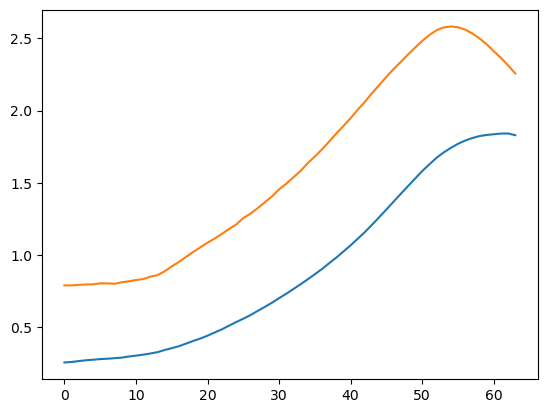

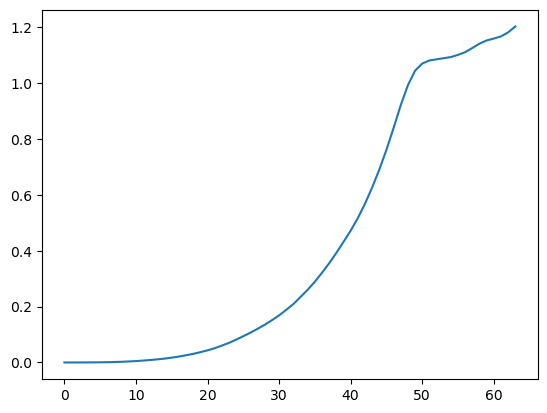

In [88]:
xm=xL.mean(axis=0)
xs=xL.std(axis=0)
ym=yL.mean(axis=0)
ys=yL.std(axis=0)
xLs=(xL.copy()).swapaxes(1,2)
yLs=(yL.copy()).swapaxes(1,2)
for i in range(1):
    xLs[:,:,i]=(xLs[:,:,i])/20.
for i in range(1,3):
    xLs[:,:,i]=(xLs[:,:,i])/10.

xLs[:,:,3]=(xLs[:,:,3])/4
#yL=(yL-ym)/ys
print(yLs.shape)
yLs[:,:,0]=yLs[:,:,0]/10
#yLs[:,:,1]=(yLs[:,:,1]/2)
plt.plot(xLs[:,:,0].mean(axis=0))
plt.plot(xLs[:,:,1].mean(axis=0))
plt.figure()
plt.plot(yLs[:,:,0].mean(axis=0))
#plt.plot(yLs[:,:,1].mean(axis=0))


In [89]:
# Define custom dataset
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
print(xL.shape)
#swap axes to get the right shape
x_train, x_test, y_train, y_test = train_test_split(xLs, yLs, test_size=0.1, random_state=42)
class CustomDataset(Dataset):
    def __init__(self, x_train, y_train, transform=None):
        self.x_train = torch.tensor(x_train, dtype=torch.float32, device='cpu')
        self.y_train = torch.tensor(y_train, dtype=torch.float32, device='cpu')
        self.transform = transform

    def __len__(self):
        return len(self.x_train)

    def __getitem__(self, idx):
        sample = self.x_train[idx], self.y_train[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample
    
dataSet=CustomDataset(x_train, y_train)
batch_size = 64
shuffle = True
train_loader = DataLoader(dataSet, batch_size=batch_size, shuffle=shuffle)

(30751, 4, 64)


In [18]:
print(x_train.shape)
print(y_train.shape)

(27675, 64, 4)
(27675, 64, 1)


In [136]:
#define optimizer and loss function
import torch.optim as optim
import torch.nn as nn

criterion = BayesLSTMLoss(lambda_=0.1)
#lstm_model=lstm(3,1,16)
lstm_model=bayesian_lstm(3,1,16,32)
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)

# Train the model
num_epochs = 40
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, outputs = data
        #print(inputs.shape)
        #print(outputs.shape)
        #break
        optimizer.zero_grad()
        outputs_p, pred_mu, pred_log = lstm_model(inputs[:,:,0:3])
        loss = criterion(outputs_p, pred_mu, pred_log, outputs)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 150 == 149:    # print every 50 mini-batches
            #print(f'Epoch {epoch+1}, Iteration {i+1}, Loss: {running_loss/i:.4f}')
            print(f'Epoch {epoch+1}, Iteration {i+1}, Loss: {running_loss/150:.4f}')
            running_loss = 0.0

Epoch 1, Iteration 150, Loss: 0.7748
Epoch 1, Iteration 300, Loss: 0.4943
Epoch 2, Iteration 150, Loss: 0.4289
Epoch 2, Iteration 300, Loss: 0.3988
Epoch 3, Iteration 150, Loss: 0.3717
Epoch 3, Iteration 300, Loss: 0.4016
Epoch 4, Iteration 150, Loss: 0.3552
Epoch 4, Iteration 300, Loss: 0.3462
Epoch 5, Iteration 150, Loss: 0.3460
Epoch 5, Iteration 300, Loss: 0.3289
Epoch 6, Iteration 150, Loss: 0.3341
Epoch 6, Iteration 300, Loss: 0.3204
Epoch 7, Iteration 150, Loss: 0.3190
Epoch 7, Iteration 300, Loss: 0.3074
Epoch 8, Iteration 150, Loss: 0.3256
Epoch 8, Iteration 300, Loss: 0.3118
Epoch 9, Iteration 150, Loss: 0.3074
Epoch 9, Iteration 300, Loss: 0.3130
Epoch 10, Iteration 150, Loss: 0.3002
Epoch 10, Iteration 300, Loss: 0.3207
Epoch 11, Iteration 150, Loss: 0.2897
Epoch 11, Iteration 300, Loss: 0.3017
Epoch 12, Iteration 150, Loss: 0.2972
Epoch 12, Iteration 300, Loss: 0.2889
Epoch 13, Iteration 150, Loss: 0.2941
Epoch 13, Iteration 300, Loss: 0.2958
Epoch 14, Iteration 150, Loss:

In [102]:
print(loss.shape)

torch.Size([64, 64, 4])


In [137]:
y_pL=[]
for i in range(20):
    y_p,mu,logvar=lstm_model(torch.tensor(x_test[:,:,:3], dtype=torch.float32, device='cpu'))
    y_pL.append(y_p.detach().numpy())
#print(y.shape)
print(np.mean(y_p.detach().numpy()),np.mean(y_test))

0.38097227 0.41560498


(3076,)
(20, 3076, 64, 1)


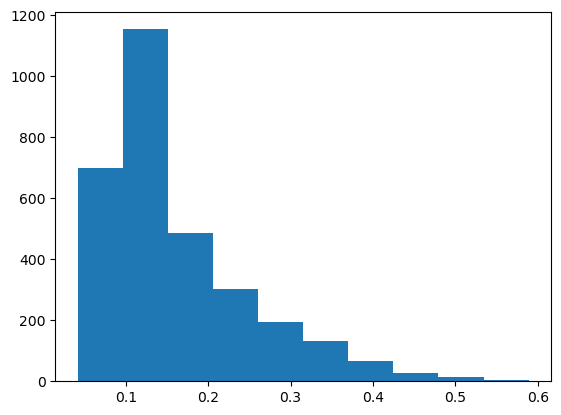

In [138]:
y_pL=np.array(y_pL)
a=np.nonzero(y_pL[0,:,-1,0]>3)
ystd=y_pL[:,:,-1,0].std(axis=(0))
print(ystd.shape)
print(y_pL.shape)
h1=plt.hist(ystd)

[[1.         0.66955055]
 [0.66955055 1.        ]]


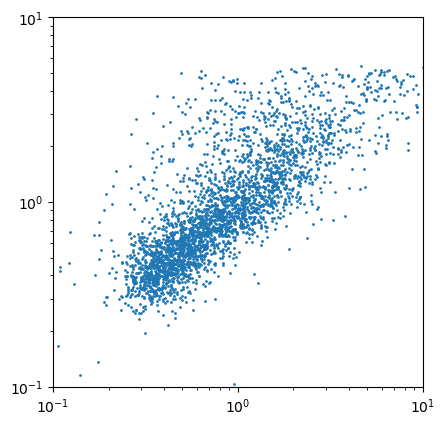

In [139]:
y_p=y_pL.mean(axis=0)
print(np.corrcoef(y_test[:,-1,0],y_p[:,-1,0]))
#print(np.corrcoef(y_test[:,-1,1],y_p[:,-1,1]))
ax=plt.subplot(111)
plt.scatter(y_test[:,-1,0],y_p[:,-1,0],s=1)
plt.xlim(0.1,10)
plt.ylim(0.1,10)
plt.xscale('log')
plt.yscale('log')
ax.set_aspect('equal')